# Propósito

- Criar um modelo preditivo que saiba diferenciar uma imagem dos seguintes jogos : Metal Gear Solid 1, The Witcher 1, Devil May Cry 1, The Last of Us 1, Red Dead Redemption 1, Dead Space 1.
## Caracterização do dado

Para isto, serão baixadas imagens buscadas pelo duck duck go.
Em seguida serão salvas nas pastas: 
[dataset/MGS1](dataset/MGS1), [dataset/DS1](dataset/DS1),
[dataset/TW1](dataset/TW1), [dataset/DMC1](dataset/DMC1),
[dataset/TLOU1](dataset/TLOU1), [dataset/RDR1](dataset/RDR1).
As imagens baixadas podem possuir largura de no máximo 400px, entretanto para sua 
análise será utilizado o método **crop** para obter imagens de 192px por 192px.

# Testando busca de imagnes

In [1]:
#hide
!pip install -Uqq fastbook
!pip install -Uqq duckduckgo_search

In [42]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [16]:
urls = search_images('Metal Gear Solid 1', max_images=3)
urls[1]

'http://3.bp.blogspot.com/-STLB-bDt510/VZaau0tX8xI/AAAAAAAAAcQ/nvSl8PMC2Mk/s1600/Metal-Gear-Solid-1-PC-Wallpaper-3.jpg'

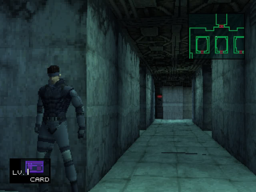

In [18]:
from fastdownload import download_url
dest = 'mgs.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

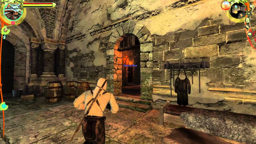

In [20]:
download_url(search_images('The Witcher 1 gameplay', max_images=1)[0], 'tw.png', show_progress=False)
Image.open('tw.png').to_thumb(256,256)

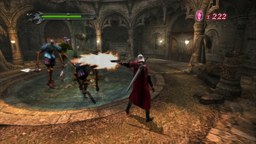

In [21]:
download_url(search_images('Devil May Cry 1 gameplay', max_images=1)[0], 'dmc.png', show_progress=False)
Image.open('dmc.png').to_thumb(256,256)

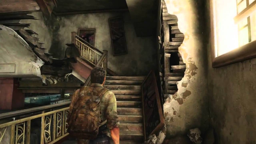

In [22]:
download_url(search_images('The Last of Us 1 gameplay', max_images=1)[0], 'tlou.png', show_progress=False)
Image.open('tlou.png').to_thumb(256,256)

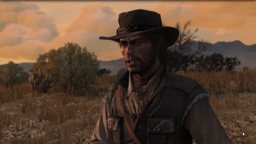

In [23]:
download_url(search_images('Red Dead Redemption 1 gameplay', max_images=1)[0], 'rdr.png', show_progress=False)
Image.open('rdr.png').to_thumb(256,256)

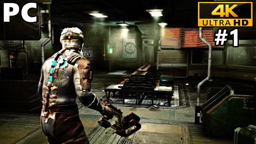

In [24]:
download_url(search_images('Dead Space 1 gameplay', max_images=1)[0], 'ds.png', show_progress=False)
Image.open('ds.png').to_thumb(256,256)

In [ ]:
## Os códigos a cima geraram duas imagens na pasta atual, esta célula apaga estas imagens. No final do notebook elas serão utilizadas para testar o código.
!rm *.jpg *.png *.jpeg

# Buscando e baixando imagens do dataset

In [34]:
from time import sleep

# Cada elemento de busca é uma tupla que possui um nome para o dataset e uma chave de busca.


searches = [
  ('MGS1','Metal Gear Solid 1'),
  ('TW1','The Witcher 1'),
  ('DMC1','Devil May Cry 1 original'),
  ('TLOU1','The Last of Us 1'),
  ('RDR1','Red Dead Redemption 1'),
  ('DS1','Dead Space 1 original')
]


images_per_search = 60

path = Path('dataset')

for element in searches:
    dest = (path/element[0])
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{element[1]} game scenes', images_per_search))

    resize_images(path/element[0], max_size=400, dest=path/element[0])

/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


In [ ]:
# Código para limpar o dataset, caso necessário.
!rm -rf dataset/*

In [35]:
# Buscando por imagens que deram erro durante o download e removendo-as
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

29

# Treinando o modelo

## Assinatura de um DataBlock  

In [9]:
?DataBlock

Init signature:
DataBlock(
    blocks: 'list' = None,
    dl_type: 'TfmdDL' = None,
    getters: 'list' = None,
    n_inp: 'int' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Docstring:      Generic container to quickly build `Datasets` and `DataLoaders`.
File:           /opt/conda/lib/python3.10/site-packages/fastai/data/block.py
Type:           type
Subclasses:     

## Assinatura da classe Resize

In [10]:
?Resize

Init signature:
Resize(
    self,
    size: 'int | tuple',
    method: 'ResizeMethod' = 'crop',
    pad_mode: 'PadMode' = 'reflection',
    resamples=(<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>),
    **kwargs,
)
Docstring:      A transform that before_call its state at each `__call__`
File:           /opt/conda/lib/python3.10/site-packages/fastai/vision/augment.py
Type:           _TfmMeta
Subclasses:     

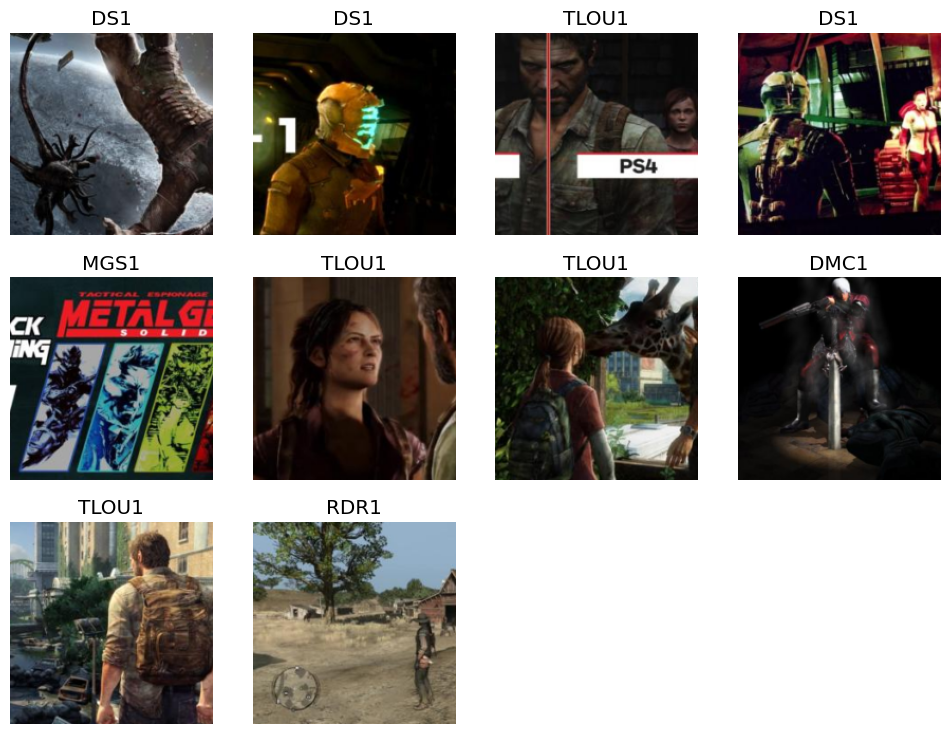

In [36]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='crop')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=10)

In [37]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.195499,0.764703,0.229167,00:41


epoch,train_loss,valid_loss,error_rate,time
0,1.002099,0.614318,0.208333,01:00
1,0.749942,0.573029,0.173611,01:00
2,0.541854,0.549964,0.173611,01:00


# Análise das imagens baixadas


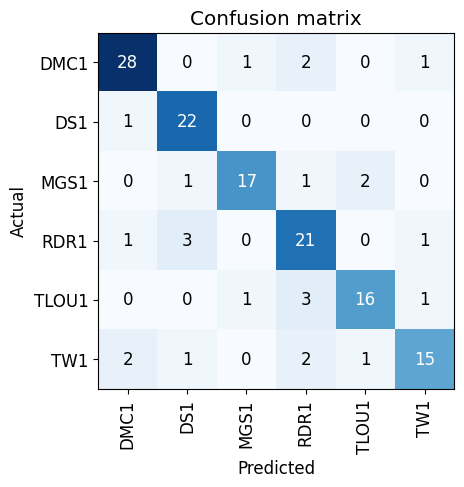

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [39]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

# Exportando o modelo

In [41]:
learn.export('model.pkl')

# Deploy

[Deploy is here](https://huggingface.co/spaces/HellSank/game_diff)